<a href="https://colab.research.google.com/github/Hercules2310/Movies_Recommender_Systems/blob/main/MovieLens%20Recommender%20System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project Name**    -  MovieLens Recommender System



## **Project Type**    - Recommender Systems
##  **BY**    - PRINCE


## ***Project Summary -***

**MovieLens is a recommender system that was developed by GroupLens, a computer science research lab at the University of Minnesota. It recommends movies to its users based on their movie ratings. It is also a dataset that is widely used in research and teaching contexts.**


## ***Problem Statement***


  Building a MovieLens Recommender System

## ***GitHub Link -***

https://github.com/Hercules2310/Movies_Recommender_Systems

## ***Import Libraries***

In [178]:
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
import warnings
warnings.filterwarnings("ignore")

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [180]:
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

In [181]:
from fuzzywuzzy import process

## ***Data***

Data Source - [grouplens.org/datasets/movielens](https://grouplens.org/datasets/movielens/)

<img src="https://recommender-tutorial.s3-us-west-2.amazonaws.com/images/download_movielens.png" width='40%'/>

### Dataset Loading

In [182]:
movies = pd.read_csv('https://raw.githubusercontent.com/Hercules2310/Movies_Recommender_Systems/main/movies.csv')      # item data

In [183]:
ratings = pd.read_csv('https://raw.githubusercontent.com/Hercules2310/Movies_Recommender_Systems/main/ratings.csv')    # user data

### Dataset First View

In [184]:
movies.head(2)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [185]:
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))

In [186]:
movies.shape

(9742, 3)

In [187]:
ratings.head(2)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247


In [188]:
ratings['timestamp']=pd.to_datetime(ratings['timestamp'],unit='s')

In [189]:
ratings.shape

(100836, 4)

In [190]:
ratings['userId'].nunique()

610

9742 movies , 100836 ratings and 610 users

### Final Dataset

In [191]:
merged_df = pd.merge(movies,ratings, on='movieId', how='inner')

In [192]:
merged_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1,4.0,2000-07-30 18:45:03
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",5,4.0,1996-11-08 06:36:02
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",7,4.5,2005-01-25 06:52:26
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",15,2.5,2017-11-13 12:59:30
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",17,4.5,2011-05-18 05:28:03


### Dataset Rows & Columns count

In [193]:
# Dataset Rows & Columns count
merged_df.shape

(100836, 6)

### Dataset Information

In [194]:
# Dataset Info
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   movieId    100836 non-null  int64         
 1   title      100836 non-null  object        
 2   genres     100836 non-null  object        
 3   userId     100836 non-null  int64         
 4   rating     100836 non-null  float64       
 5   timestamp  100836 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 4.6+ MB


## ***Variables***

In [195]:
# Dataset Columns
merged_df.columns

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')

In [196]:
merged_df['timestamp']

,timestamp
0,2000-07-30 18:45:03
1,1996-11-08 06:36:02
2,2005-01-25 06:52:26
3,2017-11-13 12:59:30
4,2011-05-18 05:28:03
...,...
100831,2018-09-16 14:44:42
100832,2018-09-16 14:52:25
100833,2018-09-16 14:56:45
100834,2018-09-16 15:00:21


In [197]:
# Dataset Describe
merged_df.describe()

,movieId,userId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,100836
mean,19435.295718,326.127564,3.501557,2008-03-19 17:01:27.368469504
min,1.000000,1.000000,0.500000,1996-03-29 18:36:55
25%,1199.000000,177.000000,3.000000,2002-04-18 09:57:46
50%,2991.000000,325.000000,3.500000,2007-08-02 20:31:02
75%,8122.000000,477.000000,4.000000,2015-07-04 07:15:44.500000
max,193609.000000,610.000000,5.000000,2018-09-24 14:27:30
std,35530.987199,182.618491,1.042529,NaN


## ***Exploratory Data Analysis***

#### Distribution of Movie ratings

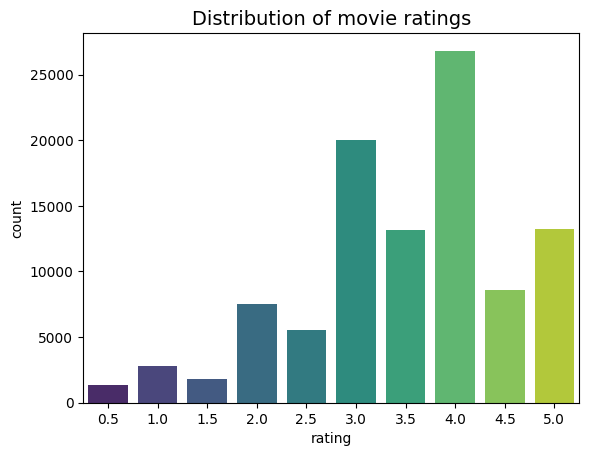

In [198]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [199]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.




*   Majority of movies are higher rated, and it makes sense otherwise how will movies generate revenue



#### Top 10 Frequency Ratings/Watched

<Axes: ylabel='title'>

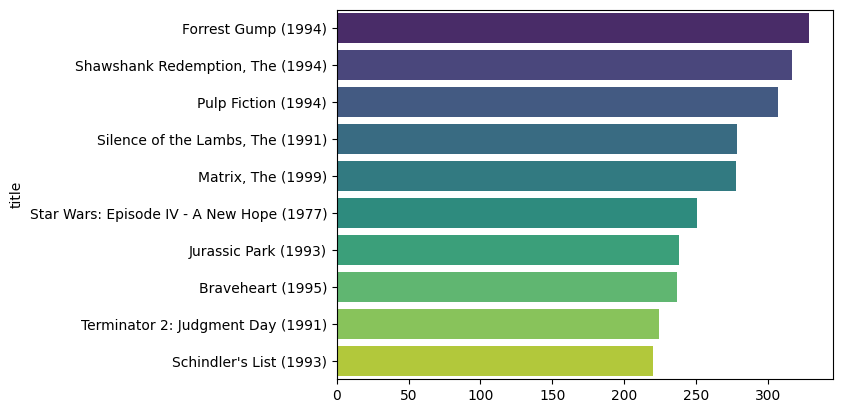

In [200]:
temp=merged_df['title'].value_counts()[:10]
sns.barplot(x=temp.values, y=temp.index,palette='viridis')

#### Mean rating of movies

In [201]:
movie_ratings_averaged = merged_df.groupby(['movieId','title']).agg(mean_rating=("rating", "mean"), count_rating=("rating", "count")).sort_values(['count_rating','mean_rating'],ascending=False).reset_index()

In [202]:
movie_ratings_averaged.head()

,movieId,title,mean_rating,count_rating
0,356,Forrest Gump (1994),4.164134,329
1,318,"Shawshank Redemption, The (1994)",4.429022,317
2,296,Pulp Fiction (1994),4.197068,307
3,593,"Silence of the Lambs, The (1991)",4.161290,279
4,2571,"Matrix, The (1999)",4.192446,278


Text(0.5, 1.0, 'movie ratings vs reviewed count')

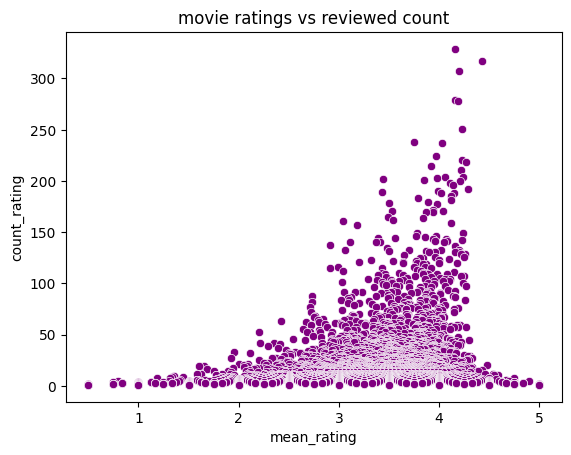

In [203]:
sns.scatterplot(data=movie_ratings_averaged,x='mean_rating',y='count_rating', color='purple')
plt.title('movie ratings vs reviewed count')

* Individually count and mean are not trustworthy for low count with high/low rating, hence using Bayesian average


#### Bayesian Average

In [204]:
C = movie_ratings_averaged['count_rating'].mean()
m = movie_ratings_averaged['mean_rating'].mean()

def bayesian_avg(row):
  movie_mean= row['mean_rating']
  movie_count=row['count_rating']
  bayesian_avg = ( C*m + movie_mean*movie_count ) / ( C + movie_count )
  return round(bayesian_avg, 3)


movie_ratings_averaged['bayesian_mean'] = movie_ratings_averaged.apply(bayesian_avg,axis=1)

In [205]:
movie_ratings_averaged.sort_values(['count_rating']).head()

,movieId,title,mean_rating,count_rating,bayesian_mean
9723,184641,Fullmetal Alchemist 2018 (2017),0.5,1,3.019
7431,110746,Hatchet III (2013),4.0,1,3.327
7430,110718,Fading Gigolo (2013),4.0,1,3.327
7429,110586,Calvary (2014),4.0,1,3.327
7428,110387,"Unknown Known, The (2013)",4.0,1,3.327


In [206]:
movie_ratings_averaged.sort_values(['bayesian_mean']).head()

,movieId,title,mean_rating,count_rating,bayesian_mean
1350,1556,Speed 2: Cruise Control (1997),1.605263,19,2.190
1349,3593,Battlefield Earth (2000),1.657895,19,2.224
805,1882,Godzilla (1998),1.954545,33,2.267
975,1499,Anaconda (1997),1.925926,27,2.297
1571,2643,Superman IV: The Quest for Peace (1987),1.687500,16,2.307


* Now these bayesian mean ratings are reliable

Text(0.5, 1.0, 'bayesian movie ratings vs reviewed count')

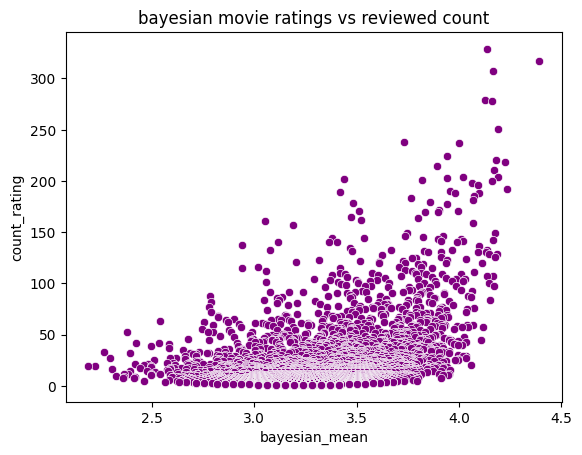

In [207]:
sns.scatterplot(data=movie_ratings_averaged,x='bayesian_mean',y='count_rating',color='purple')
plt.title('bayesian movie ratings vs reviewed count')

#### Genres of Movies

In [208]:
movie_genres_counts=movies['genres'].explode().value_counts().reset_index()

In [209]:
genres= movie_genres_counts['genres'].tolist()

In [210]:
genres

['Drama',
 'Comedy',
 'Thriller',
 'Action',
 'Romance',
 'Adventure',
 'Crime',
 'Sci-Fi',
 'Horror',
 'Fantasy',
 'Children',
 'Animation',
 'Mystery',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'IMAX',
 'Film-Noir',
 '(no genres listed)']

Text(0.5, 1.0, 'Genres_Count')

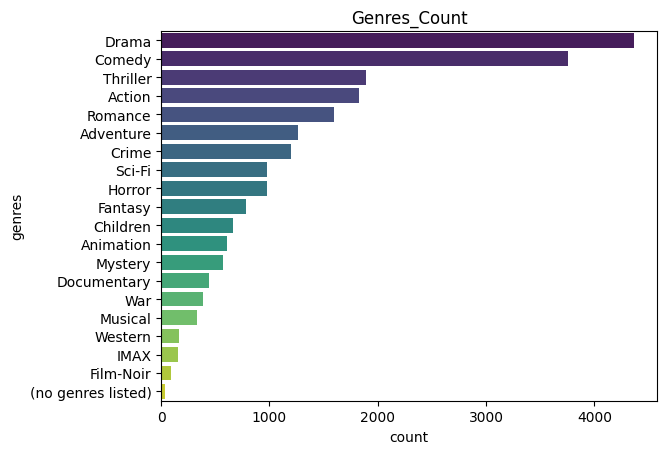

In [211]:
sns.barplot(data=movie_genres_counts,x='count',y='genres',palette="viridis")
plt.title('Genres_Count')

* Out of all the 20 genres of movies that are made, most of the movies belongs to Drama, Comedy, Thriller, Action, Comedy, Romance. Film Makers are more inclined to create these movies due to pre-established audience for higher revenue

#### Users Per Movie

In [212]:
movie_frequency=merged_df.groupby('movieId')['userId'].count().values

In [213]:
print('highest frequency for movie',movie_frequency.max() )

highest frequency for movie 329


In [214]:
print('minimum frequency for movie',movie_frequency.min() )

minimum frequency for movie 1


<Axes: ylabel='Density'>

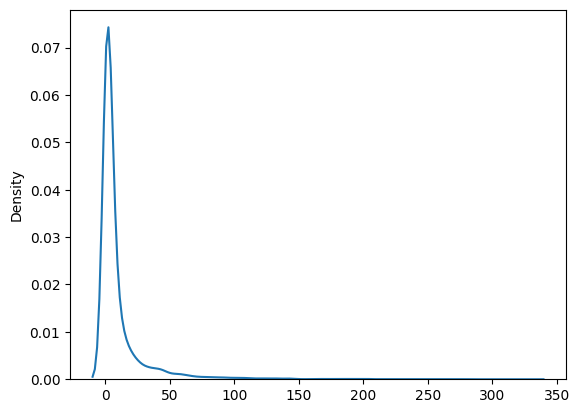

In [215]:
sns.kdeplot(movie_frequency)

#### Movies Per User

In [216]:
user_frequency=merged_df.groupby('userId')['movieId'].count().values

In [217]:
print('highest frequency for user',user_frequency.max())

highest frequency for user 2698


In [218]:
print('minimum frequency for user',user_frequency.min() )

minimum frequency for user 20


<Axes: ylabel='Density'>

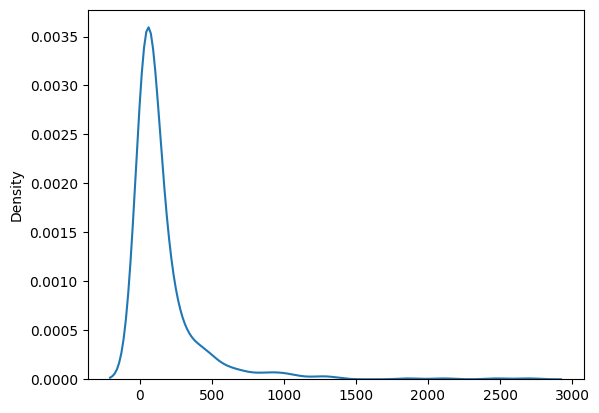

In [219]:
sns.kdeplot(user_frequency)

## ***Data Preprocessing***

#### Data SPlitting

In [220]:
train_ratings, test_ratings = train_test_split(ratings, test_size=0.2, shuffle=False)

#### Create user-item mappings

In [221]:
# Create user-item mappings
n_users = ratings['userId'].nunique()
n_items = ratings['movieId'].nunique()
user_mapper = {user: idx for idx, user in enumerate(ratings['userId'].unique())}
item_mapper = {item: idx for idx, item in enumerate(ratings['movieId'].unique())}
inverse_user_mapper = {v: k for k, v in user_mapper.items()}  # For reverse mapping
inverse_item_mapper = {v: k for k, v in item_mapper.items()}  # For reverse mapping

# Map the train and test data
train_ratings['user_index'] = train_ratings['userId'].map(user_mapper)
train_ratings['item_index'] = train_ratings['movieId'].map(item_mapper)
test_ratings['user_index'] = test_ratings['userId'].map(user_mapper)
test_ratings['item_index'] = test_ratings['movieId'].map(item_mapper)

#### Normalize the ratings

In [222]:
# Normalize the ratings by subtracting the user's mean rating
user_mean_rating = train_ratings.groupby('user_index')['rating'].mean()
train_ratings = train_ratings.copy()
train_ratings['normalized_rating'] = train_ratings.apply(lambda x: x['rating'] - user_mean_rating[x['user_index']], axis=1)

#### User Item Matrix

In [223]:
# Create CSR matrix for the training set
train_matrix = csr_matrix((train_ratings['normalized_rating'],
                           (train_ratings['user_index'], train_ratings['item_index'])),
                           shape=(n_users, n_items))

#### Evaluating Sparsity

In [224]:
n_total = train_matrix.shape[0]*train_matrix.shape[1]
n_ratings = train_matrix.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.36%


## ***Training And Evaluation***

#### Memory Based approach with Item Based Collaborative Filtering

In [225]:
# Initialize KNN model with cosine similarity
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(train_matrix.T)  # Transposing the matrix for item-based collaborative filtering as KNN calculates similarity between rows

NearestNeighbors(algorithm='brute', metric='cosine')

In [226]:
#  Define prediction function using KNN
def predict_rating(user_index, item_index, knn_model, train_matrix, user_mean_rating, k=5):
    # Ensure indices are within range
    if user_index >= train_matrix.shape[0] or item_index >= train_matrix.shape[1]:
        return np.nan  # Return NaN if indices are out of bounds

    # Handle case where the item_index is not in the matrix
    if not (0 <= item_index < train_matrix.shape[1]):
        return np.nan

    # Convert item_index to row format for the KNN model
    item_row = train_matrix.T[item_index].reshape(1, -1)  # Transpose back for user-based

    # Find k nearest neighbors for the item
    distances, indices = knn_model.kneighbors(item_row, n_neighbors=k)

    # Weighted average of the neighbors' normalized ratings
    total_weighted_rating = 0
    total_similarity = 0
    for i in range(k):
        neighbor_index = indices[0][i]
        distance = distances[0][i]
        if neighbor_index < train_matrix.shape[1] and train_matrix[user_index, neighbor_index] > 0:
            similarity = 1 - distance  # Cosine similarity = 1 - distance
            total_weighted_rating += similarity * train_matrix[user_index, neighbor_index]
            total_similarity += similarity

    if total_similarity > 0:
        normalized_prediction = total_weighted_rating / total_similarity
        return normalized_prediction + user_mean_rating.get(user_index, np.nan)  # Use .get to handle missing indices
    else:
        return user_mean_rating.get(user_index, np.nan)  # Default to NaN if no neighbors found

In [227]:
#  Make predictions on the test set and filter out invalid indices
test_ratings['predicted_rating'] = test_ratings.apply(lambda x: predict_rating(x['user_index'], x['item_index'],knn_model,train_matrix,  user_mean_rating), axis=1)

test_ratings = test_ratings.dropna(subset=['predicted_rating'])  # Drop rows with NaN predictions

In [228]:
#  Evaluate the recommender system using RMSE
rmse = np.sqrt(mean_squared_error(test_ratings['rating'], test_ratings['predicted_rating']))
print(f'RMSE: {rmse}')

RMSE: 0.6606100493079974


In [229]:
# Function to get top N recommendations for a given user
def get_top_n_recommendations(user_id, knn_model, train_matrix, user_mean_rating, movies_df, n=5, k=5):
    user_index = user_mapper.get(user_id, None)

    if user_index is None:
        print("User ID not found.")
        return []

    # Predict ratings for all items for this user
    user_ratings = []
    for item_index in range(train_matrix.shape[1]):
        if train_matrix[user_index, item_index] == 0:  # Only predict for items the user hasn't rated
            predicted_rating = predict_rating(user_index, item_index, knn_model, train_matrix, user_mean_rating, k=k)
            if predicted_rating is not np.nan:
                user_ratings.append((item_index, predicted_rating))

    # Sort by predicted rating and get top N recommendations
    top_n_recommendations = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]

    # Retrieve movie names
    top_n_movies = [(movies_df[movies_df['movieId'] == item_id]['title'].values[0], rating)
                    for item_id, rating in top_n_recommendations]

    return top_n_movies

In [230]:
#  Get top 5 recommendations for a specific user

user_id=1
n=5
k=5
top_recommendations = get_top_n_recommendations(user_id, knn_model, train_matrix, user_mean_rating, movies, n, k)

print("Top 5 Recommendations for User 1:")
for movie, rating in top_recommendations:
    print(f"{movie}: {rating}")

Top 5 Recommendations for User 1:
Eat Drink Man Woman (Yin shi nan nu) (1994): 5.0
Exit to Eden (1994): 5.0
Forget Paris (1995): 5.0
Little Women (1994): 5.0
Legends of the Fall (1994): 5.0


With Memory Based approach, the RMSE is coming out to be 0.66

#### Model Based approach with Item Based Collaborative Filtering

In [231]:
# Initialize SVD model
svd_model = TruncatedSVD(n_components=20,n_iter=10)  # Adjust n_components as needed

# Convert sparse matrix to dense format before fitting
train_matrix_dense = train_matrix.toarray()  # Convert if train_matrix is sparse

# Fit and transform the training matrix
user_latent_features = svd_model.fit_transform(train_matrix_dense)  # (n_users, n_components)
item_latent_features = svd_model.components_.T  # (n_items, n_components)

In [232]:
def predict_rating_svd(user_index, item_index, user_latent_features, item_latent_features, user_mean_rating):
    # Ensure indices are within range
    if user_index >= user_latent_features.shape[0] or item_index >= item_latent_features.shape[0]:
        return np.nan

    # Check if the user has rated the item
    if train_matrix_dense[user_index, item_index] > 0:
        return train_matrix_dense[user_index, item_index]

    # Get latent vectors
    user_vector = user_latent_features[user_index, :]
    item_vector = item_latent_features[item_index, :]

    # Compute predicted rating
    predicted_rating = np.dot(user_vector, item_vector)

    # Adjust for user's mean rating
    return predicted_rating + user_mean_rating.get(user_index, 0)

In [233]:
# Make predictions on the test set and filter out invalid indices
test_ratings['predicted_rating'] = test_ratings.apply(
    lambda x: predict_rating_svd(x['user_index'], x['item_index'], user_latent_features, item_latent_features, user_mean_rating), axis=1)
test_ratings = test_ratings.dropna(subset=['predicted_rating'])  # Drop rows with NaN predictions

In [234]:
# Evaluate the recommender system using RMSE
rmse = np.sqrt(mean_squared_error(test_ratings['rating'], test_ratings['predicted_rating']))
print(f'RMSE: {rmse}')

RMSE: 0.6537261982253526


In [235]:
def get_top_n_recommendations(user_id, user_latent_features, item_latent_features, user_mean_rating, movies_df, n=5):
    user_index = user_mapper.get(user_id, None)

    if user_index is None:
        print("User ID not found.")
        return []

    # Predict ratings for all items for this user
    user_ratings = []
    for item_index in range(item_latent_features.shape[0]):
        if train_matrix_dense[user_index, item_index] == 0:  # Only predict for items the user hasn't rated
            predicted_rating = predict_rating_svd(user_index, item_index, user_latent_features, item_latent_features, user_mean_rating)
            if not np.isnan(predicted_rating):
                user_ratings.append((item_index, predicted_rating))

    # Sort by predicted rating and get top N recommendations
    top_n_recommendations = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]

    # Retrieve movie names
    top_n_movies = [(movies_df[movies_df['movieId'] == inverse_item_mapper[item_id]]['title'].values[0], rating)
                    for item_id, rating in top_n_recommendations]

    return top_n_movies

In [236]:
def get_top_n_recommendations_svd(user_id, train_matrix_svd, item_latent_features, user_mean_rating, movies_df, n=5):
    # Get the user index from the user ID
    user_index = user_mapper.get(user_id, None)

    if user_index is None:
        print("User ID not found.")
        return []

    user_ratings = []

    # Loop over all items to predict ratings for unrated items
    for item_index in range(train_matrix_dense.shape[1]):
        if train_matrix_dense[user_index, item_index] == 0:  # Only predict for items the user hasn't rated
            predicted_rating = predict_rating_svd(user_index, item_index, train_matrix_svd, item_latent_features, user_mean_rating)
            if not np.isnan(predicted_rating):
                user_ratings.append((item_index, predicted_rating))

    # Sort the items by predicted rating in descending order and select the top N
    top_n_recommendations = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:n]

    # Retrieve movie names for the top N recommendations
    top_n_movies = [(movies_df[movies_df['movieId'] == item_id]['title'].values[0], rating)
                    for item_id, rating in top_n_recommendations]

    return top_n_movies

In [237]:
# Example usage:
user_id = 1
n = 5  # Number of recommendations
top_recommendations = get_top_n_recommendations(user_id, user_latent_features, item_latent_features, user_mean_rating, movies, n)

print("Top 5 Recommendations for User 1:")
for movie, rating in top_recommendations:
    print(f"{movie}: {rating}")

Top 5 Recommendations for User 1:
Shawshank Redemption, The (1994): 4.617386925759819
Blade Runner (1982): 4.616447756425807
Godfather, The (1972): 4.6072890125722825
Rear Window (1954): 4.594020953437521
Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000): 4.582467691717531


## ***Cold Start Problem***

#### For New Users collaborative filtering will not work, hence going with content based

In [238]:
genres

['Drama',
 'Comedy',
 'Thriller',
 'Action',
 'Romance',
 'Adventure',
 'Crime',
 'Sci-Fi',
 'Horror',
 'Fantasy',
 'Children',
 'Animation',
 'Mystery',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'IMAX',
 'Film-Noir',
 '(no genres listed)']

In [239]:
for g in genres:
    movies[g] = movies['genres'].apply(lambda x: int(g in x))

movie_genres = movies.drop(columns=['movieId', 'title','genres'])

In [240]:
movies['movieId'].nunique()  # Number of Unique Movies

9742

In [241]:
movie_genres

,Drama,Comedy,Thriller,Action,Romance,Adventure,Crime,Sci-Fi,Horror,Fantasy,Children,Animation,Mystery,Documentary,War,Musical,Western,IMAX,Film-Noir,(no genres listed)
0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
9738,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
9739,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9740,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#### Content based recommendations

In [242]:
cosine_sim = cosine_similarity(movie_genres, movie_genres)
cosine_sim

array([[1.        , 0.77459667, 0.31622777, ..., 0.        , 0.31622777,
        0.4472136 ],
       [0.77459667, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 1.        , ..., 0.        , 0.        ,
        0.70710678],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.4472136 , 0.        , 0.70710678, ..., 0.        , 0.        ,
        1.        ]])

In [243]:
cosine_sim.shape

(9742, 9742)

In [244]:
titles=movies['title'].tolist()
movie_mapper = {el:idx for idx,el in enumerate(movies['title'])}

In [245]:
def get_recommendations(for_movie,n=5):
  title = lambda for_movie: process.extractOne(for_movie,titles)[0]
  idx = movie_mapper[title(for_movie)]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:(n+1)]
  similar_movies = [i[0] for i in sim_scores]
  return movies['title'].iloc[similar_movies]

In [246]:
movie='jumanji'
n_recommendations=5
print(get_recommendations(movie, n_recommendations))

53             Indian in the Cupboard, The (1995)
109             NeverEnding Story III, The (1994)
767               Escape to Witch Mountain (1975)
1514    Darby O'Gill and the Little People (1959)
1556                          Return to Oz (1985)
Name: title, dtype: object


## ***Thank You***